# EUNIS habitat mapping in openEO - run of the inference part to generate habitat occurrence probabilities
In this notebook we generate the occurrence probability maps for each EUNIS habitat in the hierarchical CatBoost ML approach. All data is processed on OpenEO. In a first step the feature cube for the requested AOI is generated (tiled if area is bigger than 20x20km), then the CatBoost models are loaded from the S3 model storage via ONNX format and applied in parallel on the data cube. The output DataCube is then saved on the S3 storage.

In [1]:
# standard
import os
import importlib.resources as importlib_resources
import geopandas as gpd
import pandas as pd
from typing import Optional, List
import platform
import traceback
import openeo
from openeo.extra.job_management import CsvJobDatabase
from openeo.rest.datacube import THIS

# WEED project developments
from eo_processing.config import get_job_options, get_collection_options, get_standard_processing_options, generate_storage_options
from eo_processing.config.settings import storage_option_format
from eo_processing.utils import laea20km_id_to_extent
from eo_processing.utils.helper import init_connection, location_visu, getUDFpath, convert_to_list
from eo_processing.utils.onnx_model_utilities import get_name_output_cube_features
from eo_processing.utils.jobmanager import WeedJobManager
from eo_processing.utils.storage import WEED_storage
from eo_processing.utils.messaging import send_email
from eo_processing.openeo.processing import generate_master_feature_cube
import eo_processing.resources

### declaration area
Here we set all the needed parameters for the run. <br>
Note: if data export to the S3 storage is needed THEN the user has to have access to the openEO "esa-weed-workspace" export workspace settings. If you also want then a local copy of the S3 saved file via the jobmanager THEN you have to initialize the WEED_storage object and therefore you need access to the Terrascope VAULT to the WEED secrets. <br> <br>
Note: in this example we use the specific file_prefix also as s3_prefix for the storage on S3 in the result folder (if you want to run tests then please use the 'tests' folder)

In [2]:
# name of test-site files on GDrive
list_paths_testsites = ['SK_test-sites_alpha1_EPSG4326.gpkg', 'CZ_test-sites_alpha1_EPSG4326.gpkg' ] # GPKG on the GDrive

# processing
file_name_base = 'alpha-1_test-sites'
version_string = 'v1'
processing_year = 2024
if platform.system() == 'Windows':
    out_root = os.path.normpath(r'\\netapp03.vgt.vito.be\habitat\slovakia\openEO_tests\alpha-1\5_inference-openEO')
else:
    out_root = os.path.normpath(r'/data/habitat/slovakia/openEO_tests/alpha-1/5_inference-openEO')
    path_recipients = os.path.normpath(r'/home/buchhornm/Documents/openEO_messaging_emails.txt')

# backend and path to model storage
backend = 'cdse'  # also possible: cdse-stagging
s3_model_directory = 'models'  # relative to WEED bucket

# S3 storage
terrascope_username = 'buchhornm' # needed for the Vault access (access to GDrive and S3)
s3_export = True     # set to False if no S3 export is wished -> then the following two parameters can be ignored)
s3_prefix = f'tests/Marcel/{file_name_base}_{version_string}' #that is the path to results in WEED bucket
local_copy_needed = True

# run some overall functions
os.makedirs(out_root, exist_ok=True)
# Note: we are using the standard entry point: "1k27bitdRp41AtHq1xupyqwKaTLzrMUMu"  which represent the openEO folder under WEEDE/Working/WP4_ToolboxDvlpt/openeo_tests
weed_storage = WEED_storage(username=terrascope_username)
# set the storage options if we need S3 workspace export - if not specified then the standard local download is used in processing and jobmanager
storage_options = generate_storage_options(workspace_export=s3_export, S3_prefix=s3_prefix, local_S3_needed=local_copy_needed, storage=weed_storage)

### get the alpha-1 test sites from the GDrive (SK and CZ)

In [3]:
# get overview of GDrive (adapt declaration area if you want to load different test-sites)
weed_storage.print_gdrive_overview()

Found directory: 1k27bitdRp41AtHq1xupyqwKaTLzrMUMu
	CZ_test-sites_alpha1_EPSG4326.gpkg
	SK_test-sites_alpha1_EPSG4326.gpkg
	European_terrestrial_LAEA20km_grid.gpkg
	global_terrestrial_UTM20k_grid.gpkg
	SK_v5_reference-points_EUNIS2012.csv
	global_terrestrial_UTM100k_grid.gpkg


In [4]:
# load the test sides into a GeoPandas GeoDataFrame
# use helper function to load the GDrive file directly
gdf_sites = [weed_storage.get_gdrive_gdf(gdrive_path=path_file) for path_file in list_paths_testsites]
gdf_sites = gpd.GeoDataFrame(pd.concat(gdf_sites, ignore_index=True))

### specify space context for the openEO run
The space context is set by intersecting the test sites (AOIs) with the openEO EU 20x20km tiling grid. Since the tiling grid has a smaller file size, it was also stored in the resources of the eo_processing package as well as on the GDrive folder. <br>

In [5]:
# get the LAEA-20km grid saved as EPSG:4326 vector
grid = importlib_resources.files(eo_processing.resources).joinpath('LAEA-20km.gpkg')
gdf_grid = gpd.read_file(os.path.normpath(grid))
# spatial intersect and retrieve the tile_ID's of the LAEA-20km grid (convert AOI to EPSG:4326 if needed)
gdf_aoi = gdf_grid[gdf_grid.intersects(gdf_sites.union_all())]

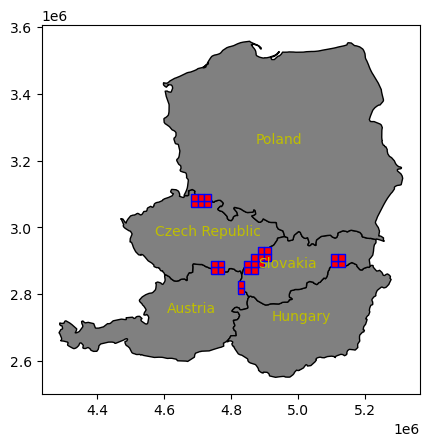

In [6]:
# visualization of the selected- tiles in the tiling grid which needs to be processed to cover the AOI
location_visu(gdf_aoi, zoom=True, region='EU', label=True)

### Integration of the MultiBackendJobManager


#### creating the jobs dataframe
The `MultiBackendJobManager` uses a jobs database to set-up, start and monitor all desired jobs. We are using Pandas/GeoPandas to create a DataFrame storing the job and all parameters which should adapted for each job.

In this example we can directly use the GeoDataFrame of the tiling grid since after the intersection with the AOI is contains only the remaining block extents to process.

Note: for the inference we have to hand over also a lot of additional data to each job like: Model_URLs, list of output band names, ....

##### preparation of specific inference parameters

In [7]:
# we need the urls for all the models to process
# ToDo: in this example the same models are applied to all tiles, later the location of a tile could define which models to run for it. Implement in the 'create_job_dataframe' function a more adjustable way to extract the model_urls from the S3 storage via the WEED_storage class.
model_urls = weed_storage.get_onnx_urls(s3_directory=s3_model_directory)

# we also need the list of the final outbut band names since we currently rename the band names
# ToDo: adapt the inference UDF that the naming of the output bands is directly done in the 'create_output_xarray` function
# ToDo: make sure that in the ONNX model itself the complete final band name of a probability layer is saved e.g. Level3_class-C1_habitat-C1.1-30101 -> adapt the `get_output_features_from_catboost` function in the pipeline_step2_ONNX-model-generation.ipynb
output_band_names = get_name_output_cube_features(model_urls)

Loaded ONNX model from /tmp/cache\Level1_class-0_129predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-C_71predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-D_68predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-E_85predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-F_90predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-G_164predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-H_65predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-I_50predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-J_62predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-X_54predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level3_class-C1_62predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level3_class-C3_62predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level3_class-E1_50predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level3_class-E2_50predictors_v1.onnx
Loaded ONNX mo

In [8]:
def create_job_dataframe(gdf: gpd.GeoDataFrame, year: int, file_name_base: str, model_urls: List[str], output_band_names: List[str],
                         target_crs: Optional[int] = None, storage_options: Optional[storage_option_format] = None) -> gpd.GeoDataFrame:

    columns = ['name', 'target_epsg', 'file_prefix', 'start_date', 'end_date', 'model_urls', 'output_band_names', 's3_prefix', 'geometry']
    dtypes = {'name': 'string', 'target_epsg': 'UInt16', 'file_prefix': 'string', 'start_date': 'string', 'end_date': 'string',
              'model_urls': 'string', 'output_band_names': 'string', 's3_prefix': 'string','geometry': 'geometry'}

    job_df = gdf.copy()

    # the time context is given by start and end date
    job_df['start_date'] = f'{year}-01-01'
    job_df['end_date'] = f'{year+1}-01-01'  # the end is always exclusive

    # adding the output file name pre-fix
    job_df['file_prefix'] = job_df.apply(lambda row: f'{file_name_base}_EUNIS-habitat-proba-cube_year{year}_{row['name']}', axis=1)

    # set the target epsg
    if target_crs is None:
        job_df['target_epsg'] = 3035
    else:
        job_df['target_epsg'] = target_crs

    # adding the model_urls and output_band_names (all the same for all tiles)
    job_df['model_urls'] = [model_urls] * len(job_df)
    job_df['output_band_names'] = [output_band_names] * len(job_df)

    # set the s3_prefix which is needed for the path to S3 storage relative to WEED bucket if we export
    job_df['s3_prefix'] = storage_options.get('S3_prefix', None)

    return job_df.astype(dtypes)

In [9]:
# create job dataframe
job_df = create_job_dataframe(gdf_aoi, year=processing_year, file_name_base=f'{file_name_base}_{version_string}', model_urls=model_urls,
                              output_band_names=output_band_names, storage_options=storage_options)

In [10]:
# show the jobs_database before conversion into a JobDatabaseInterface
job_df.head()

,name,geometry,start_date,end_date,file_prefix,target_epsg,model_urls,output_band_names,s3_prefix
10242,E468N306,"MULTIPOLYGON (((15.06861 50.54001, 15.08805 50...",2024-01-01,2025-01-01,alpha-1_test-sites_v1_EUNIS-habitat-proba-cube...,3035,['https://s3.waw3-1.cloudferro.com/swift/v1/ec...,"['Level1_class-0_129predictors_v1_30000', 'Lev...",tests/Marcel/alpha-1_test-sites_v1
10243,E468N308,"MULTIPOLYGON (((15.08805 50.71931, 15.10767 50...",2024-01-01,2025-01-01,alpha-1_test-sites_v1_EUNIS-habitat-proba-cube...,3035,['https://s3.waw3-1.cloudferro.com/swift/v1/ec...,"['Level1_class-0_129predictors_v1_30000', 'Lev...",tests/Marcel/alpha-1_test-sites_v1
10428,E470N306,"MULTIPOLYGON (((15.35009 50.52723, 15.3706 50....",2024-01-01,2025-01-01,alpha-1_test-sites_v1_EUNIS-habitat-proba-cube...,3035,['https://s3.waw3-1.cloudferro.com/swift/v1/ec...,"['Level1_class-0_129predictors_v1_30000', 'Lev...",tests/Marcel/alpha-1_test-sites_v1
10429,E470N308,"MULTIPOLYGON (((15.3706 50.70648, 15.3913 50.8...",2024-01-01,2025-01-01,alpha-1_test-sites_v1_EUNIS-habitat-proba-cube...,3035,['https://s3.waw3-1.cloudferro.com/swift/v1/ec...,"['Level1_class-0_129predictors_v1_30000', 'Lev...",tests/Marcel/alpha-1_test-sites_v1
10611,E472N306,"MULTIPOLYGON (((15.63143 50.51377, 15.65301 50...",2024-01-01,2025-01-01,alpha-1_test-sites_v1_EUNIS-habitat-proba-cube...,3035,['https://s3.waw3-1.cloudferro.com/swift/v1/ec...,"['Level1_class-0_129predictors_v1_30000', 'Lev...",tests/Marcel/alpha-1_test-sites_v1


#### creating the job `start_job` function
The next step is to define a `start_job` function. This function will instruct the `MultiBackendJobManager` on how to initiate a new job on the selected backend. The `start_job` functionality should adhere to the following structure _start_job(row: pd.Series, connection: openeo.Connection, **kwargs)_. <br><br>
Note: the start_job function can only use parameters which are hand over from the job_dataframe! Complex objects like the WEED_storage class can not be used therefore. Geometries can be serialized and stored in the Pandas/GeoPandas row as `geojson.FeatureCollection`.

In [11]:
def inference(row: gpd.GeoSeries, connection: openeo.Connection, provider: str , **kwgs) -> openeo.BatchJob:
    """Start a new job using the specified row out of the jobs GeoDataFrame and connection."""

    #### parameter section
    # extract needed parameters from the dataframe row
    tileID = row["name"]
    start = row["start_date"]
    end = row["end_date"]
    file_name = row["file_prefix"]
    epsg = int(row["target_epsg"])
    model_urls = convert_to_list(row["model_urls"])
    output_band_names = convert_to_list(row["output_band_names"])
    s3_prefix = row["s3_prefix"]

    # convert the row name into a openEO bbox dict giving the spatial extent of the job
    processing_extent = laea20km_id_to_extent(tileID)
    # define job_options, processing_options,  and collection_options
    job_options = get_job_options(provider=provider, task='inference')
    collection_options = get_collection_options(provider=provider)
    processing_options = get_standard_processing_options(provider=provider, task='feature_generation')
    # adapt the epsg to the processing grid
    processing_options.update(target_crs = epsg)

    #### create the feature cube
    # define the S1/S2 processed feature cube (Note: do not set spatial extent since we hand it over in the end)
    data_cube = generate_master_feature_cube(connection,
                                             None,
                                             start,
                                             end,
                                             **collection_options,
                                             **processing_options)

    # now we merge in the NON ON-DEMAND processed features (DEM and WENR features)
    # load the DEM from a CDSE collection
    DEM = connection.load_collection(
        "COPERNICUS_30",
        bands=["DEM"])
    # reduce the temporal domain since copernicus_30 collection is "special" and feature only are one time stamp
    DEM = DEM.reduce_dimension(dimension='t', reducer=lambda x: x.last(ignore_nodata=True))
    # resample the cube to 10m and EPSG of corresponding 20x20km grid tile
    DEM = DEM.resample_spatial(projection=processing_options['target_crs'],
                               resolution=processing_options['resolution'],
                               method="bilinear")
    # merge into the S1/S2 data cube
    data_cube = data_cube.merge_cubes(DEM)

    # load the WERN features from public STAC
    WENR = connection.load_stac("https://stac.openeo.vito.be/collections/wenr_features")
    # resample the cube to 10m and EPSG of corresponding 20x20km grid tile
    WENR = WENR.resample_spatial(projection=processing_options['target_crs'],
                                 resolution=processing_options['resolution'],
                                 method="near")
    # drop the time dimension
    try:
        WENR = WENR.drop_dimension('t')
    except:
        # workaround if we still have the client issues with the time dimensions for STAC dataset with only one time stamp
        WENR.metadata = WENR.metadata.add_dimension("t", label=None, type="temporal")
        WENR = WENR.drop_dimension('t')
    # merge into the S1/S2 data cube
    data_cube = data_cube.merge_cubes(WENR)

    # filter spatial the whole cube
    data_cube = data_cube.filter_bbox(processing_extent)

    #### run multi-model inference
    #we pass the model url as context information within the UDF
    udf  = openeo.UDF.from_file(
            getUDFpath('udf_catboost_inference.py'),
            context={"model_list": model_urls})

    # Apply the UDF to the data cube.
    proba_cube = data_cube.apply_dimension(process=udf, dimension = "bands")

    # extra posprocessing (band label renaming and scaling)
    proba_cube = proba_cube.rename_labels(dimension="bands",target=output_band_names)
    proba_cube = proba_cube.linear_scale_range(0,100, 0,100)

    #### create job progress graph including storage to S3
    saved_cube = proba_cube.save_result(format="GTiff",
                                        options={
                                            'separate_asset_per_band': True,
                                            'filename_prefix': file_name,
                                        })
    if pd.isna(s3_prefix):
        cube_workspace = saved_cube
    else:
        cube_workspace = saved_cube.process("export_workspace",
                                            arguments={
                                                'data': THIS,
                                                'workspace': 'esa-weed-workspace',
                                                'merge': s3_prefix
                                            })
    job = cube_workspace.create_job(title=file_name,
                                    description=f'inference for tile {tileID}',
                                    job_options=job_options)
    return job

#### run the jobs
With our jobs database and job definition set up, we can now run the jobs using the `MultiBackendJobManager`. This involves defining a path to where we will store the job tracker which contains the job statuses and metadata.
<br> <br>
Note: If the specified job tracker path, points to an existing jobs database (either a .csv or .parquet file), that file will be used as the job tracker, and the input jobs database will be disregarded.

In [12]:
# for test
# ToDo: delete after tests!!!!!
job_df = job_df.head(1)

In [13]:
# generate a unique name for the job tracker database (here: CSV file)
job_tracker = os.path.normpath(os.path.join(out_root, f'job_tracker_{file_name_base}_{version_string}_inference-openEO.csv'))
# init of MultiBackendJobManager (A viz switch has been added to enable vizualization of status)
manager = WeedJobManager(root_dir=out_root, poll_sleep=30, storage_options=storage_options, viz=False)
# create a connection to backend and add this active backend to the jobmanager
connection = init_connection(backend)
manager.add_backend(backend, connection=connection, parallel_jobs=15)

Authenticated using refresh token.


In [14]:
def reset_tracker_file(path_tracker: str) -> None:
    """
    Resets the statuses of jobs in a tracker file to allow reprocessing. The function reads a
    CSV file containing job information, modifies specific statuses, and writes the modified
    data back to the file. It identifies non-error and downloading-related statuses and updates
    them accordingly. A summary of the number of reset rows is printed to the console.

    :param path_tracker: Path to the tracker CSV file. The file is expected to have
        columns such as 'status' and 'attempt'.
    :return: None
    """
    count = 0
    df_tracker = pd.read_csv(path_tracker)
    non_error_statuses = ['created', 'queued', 'start_failed', 'skipped',
                          'canceled', 'error_openeo']
    # Iterate through each row in the DataFrame
    for index, row in df_tracker.iterrows():
        # check for the always downloaded job file
        # ToDO: implement the path generation for the job file and check if exist on disk

        # Reset statuses for non-error-related jobs
        if row['status'] in non_error_statuses:
            df_tracker.at[index, 'status'] = 'not_started'
            count+=1
        # Reset statuses for downloading issues
        if row['status'] in ['error_downloading', 'downloading']:
            df_tracker.at[index, 'status'] = 'running'
            df_tracker.at[index, 'attempt'] = 1
            count+=1
    df_tracker.to_csv(path_tracker, index=False)
    print(f'overall {count} job rows in the tracker file were reset. You can manually restart the job processing.')

In [ ]:
# due to a bug in the JobManager class we first have to create the CSVJobDatabase by ourself and write it to disk so that we get all custom columns! Note: still loads existing one if no file exists on drive.
job_db = CsvJobDatabase(path=job_tracker)
if job_db.exists():
    print(f"Resuming `run_jobs` from existing {job_db}")
else:
    df = manager._normalize_df(job_df)
    job_db.persist(df)

# now start the jobs with the prepared JobDatabase object
try:
    manager.run_jobs(start_job=inference, job_db=job_db)
    if platform.system() != 'Windows':
        send_email(path_recipients,
                   'TD feature extraction SUCCESSFUL',
                   f'Processing successful. Data can be found here: {out_root}')
except Exception as e:
    tinfo = traceback.format_exc()
    if platform.system() != 'Windows':
        send_email(path_recipients,
                   'TD feature extraction FAILED',
                   f'Processing FAILED. Check error logs here: {out_root}\n\n{str(e)}\n\n{str(tinfo)}')
    print(str(e))
    print(tinfo)
    # reset the job_tracker file for the next run
    reset_tracker_file(job_tracker)

Resuming `run_jobs` from existing CsvJobDatabase('\\\\netapp03.vgt.vito.be\\habitat\\slovakia\\openEO_tests\\alpha-1\\5_inference-openEO\\job_tracker_alpha-1_test-sites_v1_inference-openEO.csv')


### validate that all needed feature data cubes are generated

In [ ]:
# load the job_tracker file into a pandas DataFrame
df_tracker = pd.read_csv(job_tracker)

In [ ]:
# Check if all values in column "status" have the value "finished"
all_finished = df_tracker['status'].eq('finished').all()
if all_finished:
    print("All jobs are finished.")
else:
    print("Some jobs are not finished. Reset the non finished status rows to 'not_started' flag and restart the manager.run_jobs() line manually.")

In [ ]:
# print the costs of the full job
print(f'The feature datacube generation {df_tracker.shape[0]} 20x20km tiles has cost overall {df_tracker.cost.sum()} credits ({df_tracker.cost.sum() * 0.01} EURO). ')